In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os
import sys
import dask
import pandas as pd
import xarray as xr
import dask.array as da
import numpy as np
from re import split
from textwrap import wrap

from skimage.filters import gaussian, threshold_otsu
from skimage import measure
from dask_image.ndfilters import uniform_filter as uf
from dask_image.ndmeasure import variance as varian
from re import split
from scipy.interpolate import griddata
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from re import split

from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib as mpl

sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(campaign='loc')[location]['path_data']
path_proj = get_pars_from_ini(campaign='loc')[location]['path_proj']

In [2]:
ds_xr = xr.open_zarr(f'{path_data}/zarr_rckd/KUsKAs_Wn/lores.zarr')
ds_xr = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())
ds_xr = ds_xr.sel(time=slice('2019-09-16 03:12:40', '2019-09-16 03:13:20'))
ds_xr

<xarray.Dataset>
Dimensions:            (bin_size: 1, cross_track: 25, time: 22, range: 456, vector: 3)
Coordinates:
    alt3d              (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 22), meta=np.ndarray>
  * cross_track        (cross_track) int64 0 1 2 3 4 5 6 ... 19 20 21 22 23 24
    lat3d              (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 22), meta=np.ndarray>
    lon3d              (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 22), meta=np.ndarray>
  * time               (time) datetime64[ns] 2019-09-16T03:12:41.799800 ... 2...
Dimensions without coordinates: bin_size, range, vector
Data variables: (12/58)
    DR                 (bin_size) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    Xat_km             (cross_track, time) float64 dask.array<chunksize=(25, 22), meta=np.ndarray>
    alt3D              (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 22), meta=np.ndarray>
    alt_nav            (cross_track, time) float64 dask.array<chunksize=(25, 22), meta=np.ndarray>
    altsurf14          (cross_track, time) float64 dask.array<chunksize=(25, 22), meta=np.ndarray>
    altsurf35          (cross_track, time) float64 dask.array<chunksize=(25, 22), meta=np.ndarray>
    ...                 ...
    vel95s             (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 22), meta=np.ndarray>
    z95s               (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 22), meta=np.ndarray>
    zhh14              (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 22), meta=np.ndarray>
    zhh14SP            (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 22), meta=np.ndarray>
    zhh35              (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 22), meta=np.ndarray>
    zhh35SP            (range, cross_track, time) float64 dask.array<chunksize=(456, 25, 22), meta=np.ndarray>

In [8]:
# last update 10/12/2021
def lee_filter(img, size, tresh=-150):
    img = np.where(np.logical_or(np.isnan(img), np.equal(img, -np.inf)),  tresh, img)
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2
    overall_variance = variance(img)
    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

def grid_data(ds_xr):
#     z = ds_xr.where(ds_xr.alt3D > 500)
    x = ds_xr.range * ds_xr.DR.values[0] * np.sin(np.deg2rad(ds_xr.azimuth))  # add roll
    y = ds_xr.alt3D * np.cos(np.deg2rad(ds_xr.azimuth))
    z = ds_xr.zhh14.where(ds_xr.alt3D > 500)
    z = lee_filter(z.values, 3)

    x_s = x.values.flatten()
    y_s = y.values.flatten()
    z_s = z.flatten()
    z_s = np.nan_to_num(z_s, 0)
    idx = x_s.argsort()
    x_s, y_s = np.take_along_axis(x_s, idx, axis=0), np.take_along_axis(y_s, idx, axis=0)
    z_s = np.take_along_axis(z_s, idx, axis=0)
    z_s[z_s == -9999] = 0
    
    ### desired gridded data
    ncols = np.abs(np.nanmax(x_s) - np.nanmin(x_s)) / 5
    nrows = np.abs(np.nanmax(y_s) - np.nanmin(y_s)) / 5
    x_new = np.linspace(x_s.min(), x_s.max(), int(ncols))
    y_new = np.linspace(y_s.min(), y_s.max(), int(nrows))
    xi, yi = np.meshgrid(x_new, y_new)
    z0 = griddata((x_s, y_s), z_s, (xi, yi), method='linear', fill_value=-9999)
    z0 = np.where(z0 > 0, z0, np.nan)
    
    return xi, yi, z0

/tmp/ipykernel_199539/18553832.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels([i for i in range(len(ds_xr.time))])


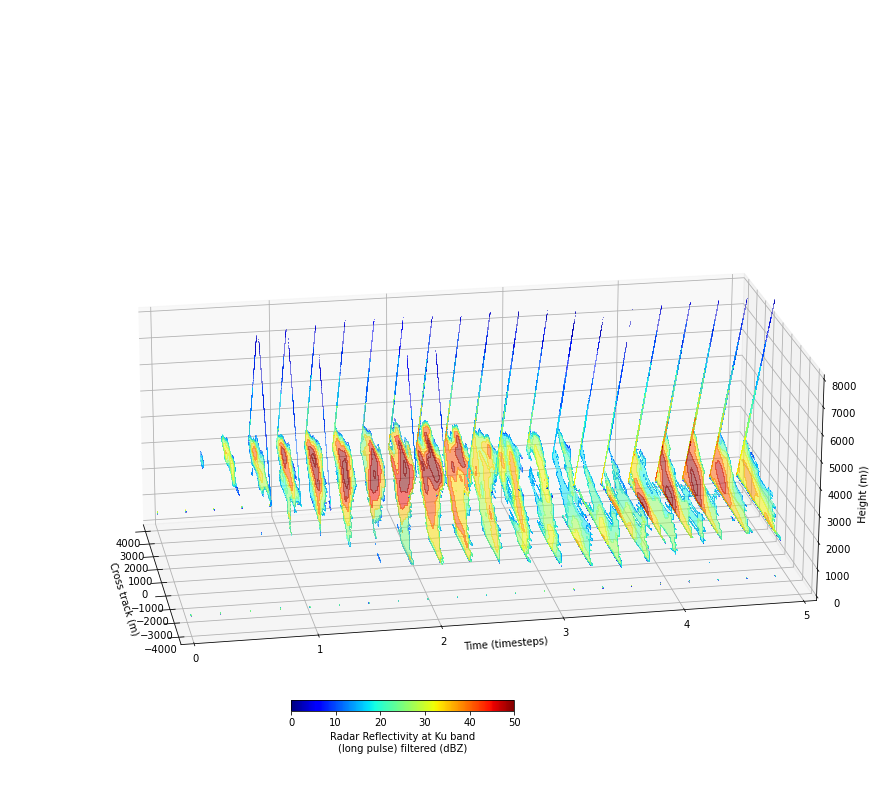

In [9]:
fig = plt.figure(figsize=(20, 15) )
ax = plt.axes(projection='3d')
a = 0
for i, _time in enumerate(ds_xr.time):
    if i != 0:
        a = i * 120
    x, y, z0  = grid_data(ds_xr=ds_xr.sel(time=_time))
    im = ax.contourf(x, z0, y, zdir='y', offset=a, cmap='jet', vmin=0, vmax=40,  alpha=0.5)

ax.set_xlabel('Cross track (m)')
ax.set_ylabel('Time (timesteps)')
ax.set_zlabel('Height (m))')
ax.set_zlim(0, 8000)
ax.set_ylim(2500,0)
ax.view_init(20,170)
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([0.5, 1, 0.5, 0.8]))


cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=50)

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    orientation='horizontal', shrink=0.2, pad=-0.12)
cbar.set_label(("\n".join(wrap(ds_xr.zhh14.notes, 30)) + ' filtered (dBZ)'))
_ = ax.set_yticklabels([i for i in range(len(ds_xr.time))])